Training: 1354 Validation: 812 Test: 542


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


max_depth = 2: Validation Macro Precision = 0.7368


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


max_depth = 3: Validation Macro Precision = 0.7255


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


max_depth = 4: Validation Macro Precision = 0.7301


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


max_depth = 5: Validation Macro Precision = 0.7186


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


max_depth = 6: Validation Macro Precision = 0.7283
Best max_depth chosen: 2


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:16:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Precision (macro-average): 0.797174037485398


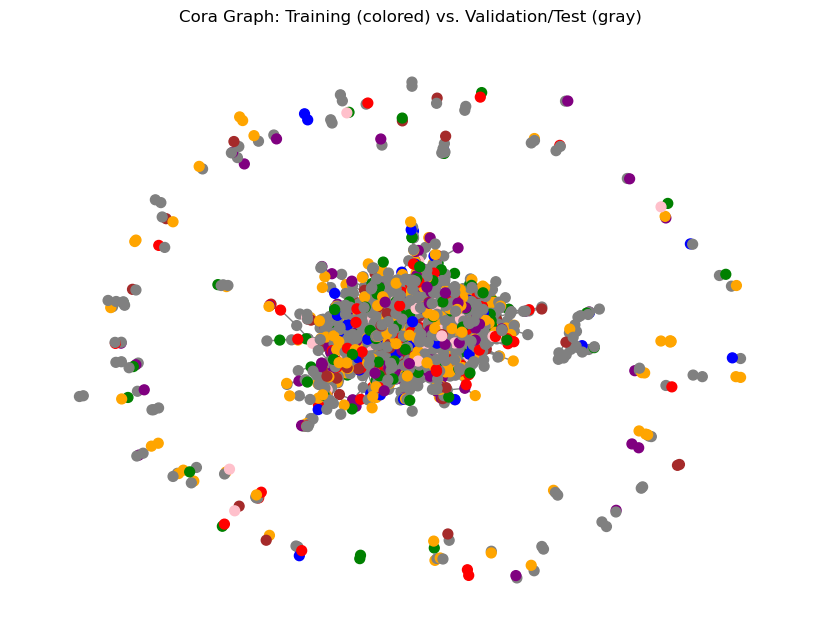

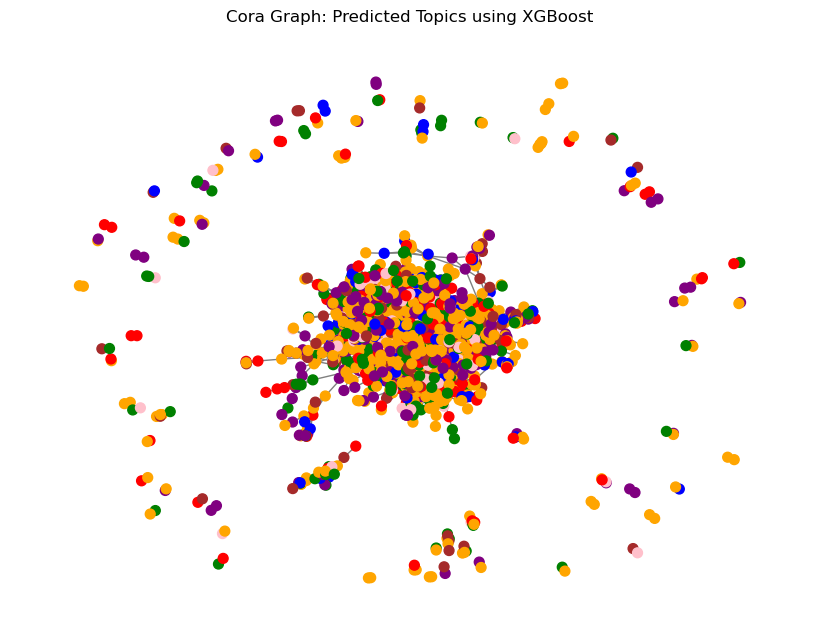

In [1]:
!pip install xgboost

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import precision_score

# --- Step 1: Load the Cora Dataset ---
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
true_labels = data.y.numpy()  # Ground-truth topics (0 to 6)

# --- Step 2: Build a NetworkX Graph from the Cora Data ---
edge_index = data.edge_index.numpy()  # shape: [2, num_edges]
G = nx.Graph()
G.add_edges_from(edge_index.T)

# --- Step 3: Compute the Laplacian Embedding ---
L = nx.normalized_laplacian_matrix(G).todense()
eigvals, eigvecs = np.linalg.eigh(L)
d = 4  # Embedding dimension
# Ignore the first trivial eigenvector (associated with eigenvalue 0)
lap_embedding = eigvecs[:, 1:1+d]  # Shape: (n_nodes, 4)

# --- Step 4: Combine Original Features with Laplacian Embedding ---
features_original = data.x.numpy()  # Original bag-of-words features
features_enriched = np.concatenate([features_original, lap_embedding], axis=1)

# --- Step 5: Split the Data (50% train, 30% validation, 20% test) ---
num_nodes = features_enriched.shape[0]
indices = np.arange(num_nodes)
np.random.seed(42)
np.random.shuffle(indices)

train_count = int(0.5 * num_nodes)
val_count   = int(0.3 * num_nodes)
test_count  = num_nodes - train_count - val_count

train_idx = indices[:train_count]
val_idx   = indices[train_count:train_count+val_count]
test_idx  = indices[train_count+val_count:]

print("Training:", len(train_idx), "Validation:", len(val_idx), "Test:", len(test_idx))

# --- Step 6: Hyperparameter Tuning with XGBoost on the Validation Set ---
candidate_depths = [2, 3, 4, 5, 6]
best_depth = None
best_score = -np.inf

for depth in candidate_depths:
    clf = XGBClassifier(max_depth=depth, random_state=42,
                        use_label_encoder=False, eval_metric='mlogloss')
    clf.fit(features_enriched[train_idx], true_labels[train_idx])
    preds_val = clf.predict(features_enriched[val_idx])
    score = precision_score(true_labels[val_idx], preds_val, average='macro', zero_division=0)
    print(f"max_depth = {depth}: Validation Macro Precision = {score:.4f}")
    if score > best_score:
        best_score = score
        best_depth = depth

print("Best max_depth chosen:", best_depth)

# --- Step 7: Retrain on Training + Validation Data ---
train_val_idx = np.concatenate([train_idx, val_idx])
clf_final = XGBClassifier(max_depth=best_depth, random_state=42,
                          use_label_encoder=False, eval_metric='mlogloss')
clf_final.fit(features_enriched[train_val_idx], true_labels[train_val_idx])
predicted_labels = clf_final.predict(features_enriched)

# --- Step 8: Evaluate on Test Data ---
test_precision = precision_score(true_labels[test_idx], predicted_labels[test_idx],
                                 average='macro', zero_division=0)
print("Test Precision (macro-average):", test_precision)

# --- Define a Color Map for the 7 Topics ---
color_map = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

# --- Plot 1: Cora Graph with Training Nodes Colored and Validation/Test Nodes in Gray ---
node_colors_plot1 = []
for i in range(num_nodes):
    if i in train_idx:
        node_colors_plot1.append(color_map[true_labels[i] % len(color_map)])
    else:
        node_colors_plot1.append('gray')

plt.figure(figsize=(8, 6))
nx.draw(G, node_color=node_colors_plot1, node_size=50, edge_color='gray', with_labels=False)
plt.title("Cora Graph: Training (colored) vs. Validation/Test (gray)")
plt.show()

# --- Plot 2: Cora Graph with All Nodes Colored by Predicted Topics ---
node_colors_plot2 = [color_map[predicted_labels[i] % len(color_map)] for i in range(num_nodes)]
plt.figure(figsize=(8, 6))
nx.draw(G, node_color=node_colors_plot2, node_size=50, edge_color='gray', with_labels=False)
plt.title("Cora Graph: Predicted Topics using XGBoost")
plt.show()